# Prévalence du Listeria dans le lait cru

In [1]:
!ls

README.md                 listeria.txt              projets2021.pdf
exploratoire_claire.ipynb mcmc.ipynb


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as rd
import statistics as stats
import math
from math import gamma
from tqdm import tqdm

In [43]:
data = pd.read_csv('listeria.txt', sep=',')
data.columns = ['nb_pos', 'nb_test']
new_row = {'nb_pos':0, 'nb_test':600}
data = data.append(new_row, ignore_index=True)

In [44]:
data['prob']=data["nb_pos"]/data['nb_test']
proba_constante = sum(data['nb_pos'])/sum(data['nb_test'])

In [45]:
proba_constante

0.0010564383073439964

# Question 1 : détermination de la loi a posteriori

On suppose dans un premier temps que la probabilité de présence de listeria dans toutes les études est constante $p$.


Modèle binomial : $r_i \sim \mathcal{B}(n_i,p)$, de fonction de masse $f(r_i, p) = \binom{n_i}{r_i} p^{r_i} (1-p)^{n_i-r_i}$ 

Loi a priori : $p \sim \mathcal{B}eta(\alpha,\beta)$ avec $\alpha, \beta = 1$ ce qui revient à avoir $p \propto \mathcal{U}([0,1])$ donc de densité $\mathbb{1}_{[0,1]}(p)$

La densité de la loi a posteriori est alors ($n$=91 est le nombre d'études) : 

$\pi(p|r_1,\dots, r_n) \propto \prod_{i=1}^{n}f(r_i,p) \mathbb{1}_{[0,1]}(p) 
\\  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto \prod_{i=1}^{n} p^{r_i} (1-p)^{(n_i-r_i)}  
\\  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto p^{\sum_{i=1}^{n}r_i} (1-p)^{\sum_{i=1}^{n}(n_i-r_i)}  \sim \mathcal{B}eta(\sum_{i=1}^{n}r_i +1, \sum_{i=1}^{n}(n_i-r_i)+1)$

Les observations nous permettent alors de calculer les deux paramètres de cette loi Bêta :


In [19]:
print("premier paramètre =",sum(data['nb_pos'])+1)
print("deuxième paramètre =",sum(data['nb_test'])-sum(data['nb_pos'])+1)

premier paramètre = 1329
deuxième paramètre = 1255727


Finalement, la loi a posteriori de $p$ est une $\boxed{\mathcal{B}eta(1329,1255727)}$

### Loi exponentielle 



In [46]:
def gen_exp(theta):
    u = rd.random()
    return -1/theta*np.log(1-u)

### Loi Gamma 
Remarque : sommer les cas/les études pour un gros échantillon
Simuler une loi beta(alpha, beta) à l'aide de simulation de lois gammas. 

------------
Soient $X$ et $Y$ deux variables independantes distribuees suivant des lois  $\Gamma(a,1)$ et $\Gamma(b,1)$

Alors $U = X+Y$ et $V = X/(X+Y)$ sont deux variables independantes distribuees suivant des lois $\Gamma(a+b,1)$ et $\mathcal{B}eta(a,b)$.





In [84]:
gamma(3)

2.0

In [77]:
def gen_gamma(a,b):
    # si alpha = 1, cela revient à avoir une loi exponentielle de paramètre beta
    if a == 1:
        return gen_exp(b)
    # si alpha est un entier non nul, gamma coïncide avec une somme de alpha va exponentielles
    # de paramètre beta indépendantes
    elif a == int(a) and a > 1 : 
        return sum([gen_exp(b) for i in range(a)])
    # sinon, on va utiliser une méthode de rejet 
    else : 
        while True : 
            # on va utiliser une loi de gamma de paramètres entiers pour g
            x = gen_gamma(int(a), b+1)
            # constante calculée dans la photo sur messenger
            c = b**a/((b+1)**int(a))*gama(int(a))/gama(a)*(a-int(a))**(a-int(a))*exp(-int(a)+a)
            u = rd.random()
            if u <= c*f(x, a, b)/g(x, int(a), b+1):
                return x 
        
        

In [78]:
def gen_beta(alpha, beta):
    X = gen_gamma(alpha, 1)
    Y = gen_gamma(beta,1)
    return X/(X+Y)

In [25]:
def gen_bernoulli(p):
    if rd.random() <= p :
        return 1
    return 0

In [26]:
def gen_binomiale(n,p):
    return sum([gen_bernoulli(p) for i in range(n)])


Représentation graphique 


Loi a posteriori : $\pi(p|r_1,\dots,r_n) \sim \mathcal{B}eta(\sum_i^n r_i+1, \sum_i^n n_i-r_i+1)$

In [31]:
list_n = data['nb_test'].tolist()
r_list = []
for elem in list_n:
    r_list.append(gen_binomiale(elem,proba_constante)) 
R = sum(r_list)+1
N = sum(list_n)-sum(r_list)+1 
R,N

(1236, 1255820)

In [ ]:
# prendre R et N directement ceux trouvés dans la loi a posteriori !

In [32]:
distr = [gen_beta(R,N) for i in range(1000)]


/home/guillot/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Distribution de la loi a posteriori')

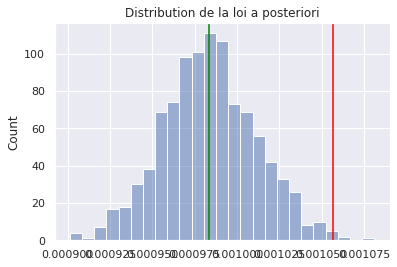

In [33]:
sns.set(style="darkgrid")
sns.histplot(distr, kde=True)
plt.axvline(proba_constante, color='red')
p_esp = sum(distr)/len(distr)
plt.axvline(p_esp, color="green")
plt.title("Distribution de la loi a posteriori")

Le modèle n'approche pas très bien la probabilité agrégée de la présence de listeria (c'est-à-dire celle prise en agrégant l'ensemble des études).
Comme le montre le graphique ci-dessous, les études affichent des probabilités empiriques de présence de listeria assez variées. Il paraît donc plus judicieux de considérer des probabilités de présence de listeria $p_i$ qui varient avec l'étude $i$.$\newline$C'est l'objet de la deuxième question.

Text(0.5, 1.0, 'Distribution des probas a priori empiriques')

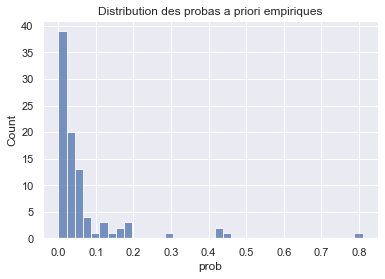

In [78]:
sns.histplot(data['prob'])
plt.title("Distribution des probas a priori empiriques")

## Question 2 : 

On suppose dans un second temps que la probabilité de présence de listeria est variable selon les études.  

Modèle binomial : $r_i \sim \mathcal{B}(n_i,p_i)$, de fonction de masse $f(r_i, p_i) = \binom{n_i}{r_i} p_i^{r_i} (1-p_i)^{n_i-r_i}$

Loi a priori : $ \forall i, p_i \sim \mathcal{B}eta(\alpha,\beta)$, de densité $\displaystyle{\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}}p_i^{\alpha-1}(1-p_i)^{\beta-1}\mathbb{1}_{[0,1]}(p_i)$

L'énoncé propose la reparamétrisation suivante : $\mu = \alpha/(\alpha+\beta) \sim \mathcal{U}([0,1])$ et $\kappa = \alpha + \beta \sim \mathcal{E}(0.1)$

On supposera que : $\textbf{$\kappa$ et $\mu$ sont indépendantes}$ 

Donc on aura la densité jointe de $(\mu,\kappa)$ suivante : $p(\mu,\kappa)$ = $0.1 e^{-0.1\kappa}\mathbb{1}_{[0,1]}(\kappa)$
     
En inversant : $\alpha = \kappa \mu $ et $\beta = \kappa (1-\mu)$

Et donc $p_i$ a pour densité (sachant $\mu$ et $\kappa$) : $p(p_i|\mu,\kappa)$  = $\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}p_i^{\kappa \mu-1}(1-p_i)^{\kappa(1-\mu)-1}\mathbb{1}_{[0,1]}(p_i)$

La densité de la loi a posteriori est alors : 

$\pi(\mu,\kappa,p_1,...,p_n|r_1,\dots, r_n) \propto \prod_{i=1}^{n}f(r_i,p_i)p(p_i|\mu,\kappa)p(\mu,\kappa)
\\    \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto \prod_{i=1}^{n} p_i^{r_i} (1-p_i)^{(n_i-r_i)}\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}p_i^{\kappa \mu-1}(1-p_i)^{\kappa(1-\mu)-1}e^{-0.1\kappa}  
\\    \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto e^{-0.1n\kappa}\left(\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}\right)^n\prod_{i=1}^{n} p_i^{r_i+\kappa \mu -1} (1-p_i)^{(n_i-r_i)+\kappa(1-\mu)-1}$ 

Contrairement au cas précédent, la loi a posteriori ne correspond pas à une loi usuelle connue. 
On va alors mettre en oeuvre un algorithme de $\textbf{Metropolis within Gibbs}$ pour simuler cette loi a posteriori, en s'appuyant sur les différentes lois (connues) de nos paramètres $(p_i)_i,\kappa$ et $\mu$.

In [155]:
# valeurs initiales plausibles pour mu, kappa et les p_i

print("valeur inititale pour mu =",0.5)              # car mu suit une uniforme sur [0,1]
print("valeur initiale pour kappa =",10)            # car kappa suit une exp(0.1) donc est de moyenne 10
print("probabilités inititales =",data['prob'])     # on prend les probas empiriques comme probas initiales

valeur inititale pour mu = 0.5
valeur initiale pour kappa = 10
probabilités inititales = 0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
        ...   
86    0.428571
87    0.437500
88    0.452632
89    0.809524
90    0.000000
Name: prob, Length: 91, dtype: float64


Version 1 : on utilise la loi beta

In [157]:
def metropolis_within_gibbs(x,sigma_1,sigma_2):
    mu=x[91]      # valeur précédente de mu
    kap=x[92]     # valeur précédente de kappa
    
    y=np.empty(93)  #initialisation d'un vecteur y qui contiendra les valeurs à l'étape suivante
    
    for i in range(0,91):
        a = mu*kap+data['nb_pos'][i]
        b = data['nb_test'][i]-data['nb_pos'][i]+kap*(1-mu)
        y[i]=np.random.beta(a,b)
    
    z = mu + sigma_1 * np.random.randn()       # proposition pour la prochaine valeur de mu 
    
    quantite_1=((1/gamma(kap*z))*(1/gamma(kap*(1-z))))**91
    quantite_2=((1/gamma(kap*mu))*(1/gamma(kap*(1-mu))))**91
    quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
    seuil=min(1,(quantite_1*quantite_3)/quantite_2)
                                                                   
    if np.random.rand() < seuil:             # on accepte z comme nouvelle valeur de mu
        y[91]=z
    
    else:
        y[91]=mu                             # on garde l'ancienne valeur de mu
    
    
    w = kap + sigma_2 * np.random.randn()         # proposition pour la prochaine valeur de kappa
    
    quantite_1=np.exp(-0.1*(w-kap))
    quantite_2=((gamma(w)/gamma(w*y[91]))*(1/gamma(w*(1-y[91]))))**91
    quantite_3=((gamma(kap)/gamma(kap*y[91]))*(1/gamma(kap*(1-y[91]))))**91
    quantite_4=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(y[91]*(w-kap))
    quantite_5=(math.prod([(1-y[i]) for i in range(0,91)]))**(w-kap)
    seuil=min(1,(quantite_1*quantite_2*quantite_3*quantite_4)/quantite_3)
        
    if np.random.rand() < seuil:             # on accepte w comme nouvelle valeur de kappa
        y[92]=w
    
    else:
        y[92]=kap                            # on garde l'ancienne valeur de kappa  

    
    return y      # on retourne le vecteur des nouvelles valeurs

In [158]:
# initialisation de notre vecteur y qui contiendra les valeurs successives de nos 93 paramètres (les 91 p_i + mu + kappa)

N = 1000
y = np.empty((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=10


# generate chain

for n in tqdm(range(1, 1000)):
    y[n] = metropolis_within_gibbs(y[n-1], sigma_1=1,sigma_2=1)

  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-157-5386e163928c>:33: RuntimeWarning: overflow encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_2*quantite_3*quantite_4)/quantite_3)
<ipython-input-157-5386e163928c>:16: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
<ipython-input-157-5386e163928c>:17: RuntimeWarning: invalid value encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_3)/quantite_2)
<ipython-input-157-5386e163928c>:33: RuntimeWarning: invalid value encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_2*quantite_3*quantite_4)/quantite_3)
  0%|          | 2/999 [00:00<00:05, 184.27it/s]


ValueError: a <= 0

Problème : on tombe rapidement dans des valeurs de alpha et beta négatives, qui rendent impossible de générer une loi beta celon ces paramètres négatifs.
On est soit obligés de réduire les écarts-types sigma_1 et sigma_2, mais dans ce cas on parcourt très peu de valeurs et l'algo ne converge pas : 

In [159]:
for n in tqdm(range(1, 1000)):
    y[n] = metropolis_within_gibbs(y[n-1], sigma_1=0.001,sigma_2=0.001)

  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-157-5386e163928c>:33: RuntimeWarning: overflow encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_2*quantite_3*quantite_4)/quantite_3)
 81%|████████▏ | 812/999 [00:03<00:00, 249.59it/s]<ipython-input-157-5386e163928c>:17: RuntimeWarning: invalid value encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_3)/quantite_2)
100%|██████████| 999/999 [00:04<00:00, 246.33it/s]


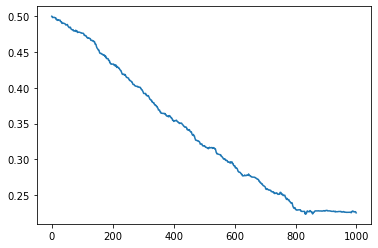

In [160]:
plt.plot(y[:,91])
# MCMC trace pour kappa

On est censés tomber sur une loi uniforme au bout d'un moment, oscillant entre 0 et 1. Là ce n'est clairement pas le cas ! L'algo se stabilise sur une plage très restreinte de valeurs, car les faibles valeurs de sigma_1 et sigma_2 ne lui ont pas permis d'explorer beaucoup de valeurs potentielles pour notre distribution mu

Version 2 : on n'utilise pas la loi beta

In [165]:
def metropolis_within_gibbs_bis(x,sigma,sigma_1,sigma_2):
    mu=x[91]      # valeur précédente de mu
    kap=x[92]     # valeur précédente de kappa
    
    y=np.empty(93)  #initialisation d'un vecteur y qui contiendra les valeurs à l'étape suivante
    
    for i in range(0,91):
        v = x[i] + sigma * np.random.randn()    # proposition pour la prochaine valeur de p_i
        
        a = data['nb_pos'][i] + kap*mu -1
        b = data['nb_test'][i]-data['nb_pos'][i]+kap*(1-mu)-1
        quantite_1 = (v/x[i])**a
        quantite_2 = ((1-v)/(1-y[i]))**b
        seuil=min(1,quantite_1*quantite_2)
        
        if np.random.rand() < seuil:             # on accepte v comme nouvelle valeur de p_i
            y[i]=v
    
        else:
            y[i]=x[i]                             # on garde l'ancienne valeur de p_i
        
    
    z = mu + sigma_1 * np.random.randn()       # proposition pour la prochaine valeur de mu 
    
    quantite_1=((1/gamma(kap*z))*(1/gamma(kap*(1-z))))**91
    quantite_2=((1/gamma(kap*mu))*(1/gamma(kap*(1-mu))))**91
    quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
    seuil=min(1,(quantite_1*quantite_3)/quantite_2)
                                                                   
    if np.random.rand() < seuil:             # on accepte z comme nouvelle valeur de mu
        y[91]=z
    
    else:
        y[91]=mu                             # on garde l'ancienne valeur de mu
    
    
    w = kap + sigma_2 * np.random.randn()         # proposition pour la prochaine valeur de kappa
    
    quantite_1=np.exp(-0.1*(w-kap))
    quantite_2=((gamma(w)/gamma(w*y[91]))*(1/gamma(w*(1-y[91]))))**91
    quantite_3=((gamma(kap)/gamma(kap*y[91]))*(1/gamma(kap*(1-y[91]))))**91
    quantite_4=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(y[91]*(w-kap))
    quantite_5=(math.prod([(1-y[i]) for i in range(0,91)]))**(w-kap)
    seuil=min(1,(quantite_1*quantite_2*quantite_3*quantite_4)/quantite_3)
        
    if np.random.rand() < seuil:             # on accepte w comme nouvelle valeur de kappa
        y[92]=w
    
    else:
        y[92]=kap                            # on garde l'ancienne valeur de kappa  

    
    return y      # on retourne le vecteur des nouvelles valeurs

In [183]:
# initialisation de notre vecteur y qui contiendra les valeurs successives de nos 93 paramètres (les 91 p_i + mu + kappa)

N = 1000
y = np.empty((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=10



# generate chain

for n in tqdm(range(1, 1000)):
    y[n] = metropolis_within_gibbs_bis(y[n-1], sigma=0.01,sigma_1=0.2,sigma_2=0.2)

  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-165-6690e1085738>:12: RuntimeWarning: divide by zero encountered in double_scalars
  quantite_1 = (v/x[i])**a
<ipython-input-165-6690e1085738>:12: RuntimeWarning: overflow encountered in double_scalars
  quantite_1 = (v/x[i])**a
<ipython-input-165-6690e1085738>:14: RuntimeWarning: invalid value encountered in double_scalars
  seuil=min(1,quantite_1*quantite_2)
<ipython-input-165-6690e1085738>:44: RuntimeWarning: overflow encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_2*quantite_3*quantite_4)/quantite_3)
<ipython-input-165-6690e1085738>:12: RuntimeWarning: invalid value encountered in double_scalars
  quantite_1 = (v/x[i])**a
<ipython-input-165-6690e1085738>:27: RuntimeWarning: invalid value encountered in double_scalars
  quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
<ipython-input-165-6690e1085738>:42: RuntimeWarning: invalid value encountered in double_scalars
  quantite_4=(math.prod(

Remarque : on prend sigma petit dans l'algo précédent car on applique l'algo de random walk dans ce cas pour simuler des probas, qui prennent des valeurs restreintes (de 0 à 1). Rien ne sert donc de prendre une forte valeur pour sigma (car on n'a pas besoin que l'algo parcourt une grande plage de valeurs).

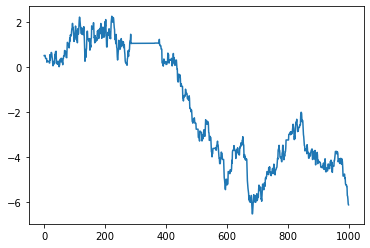

In [184]:
plt.plot(y[:,91])

# MCMC trace pour mu

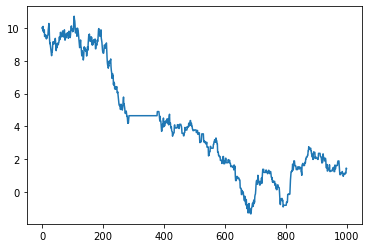

In [185]:
plt.plot(y[:,92])

# MCMC trace pour kappa

problème : il faudrait augmenter les valeurs de sigma_ et sigma_3 (respectivement à 0.3 et 10) mais quand on le fait, il y a une erreur numérique (le calcul d'une quantité mobilise trop de place). Illustration : 

In [186]:
# initialisation de notre vecteur y qui contiendra les valeurs successives de nos 93 paramètres (les 91 p_i + mu + kappa)

N = 1000
y = np.empty((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=10


for n in tqdm(range(1, 1000)):
    y[n] = metropolis_within_gibbs_bis(y[n-1], sigma=0.01,sigma_1=0.3,sigma_2=10)

  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-165-6690e1085738>:12: RuntimeWarning: divide by zero encountered in double_scalars
  quantite_1 = (v/x[i])**a
<ipython-input-165-6690e1085738>:12: RuntimeWarning: overflow encountered in double_scalars
  quantite_1 = (v/x[i])**a
<ipython-input-165-6690e1085738>:14: RuntimeWarning: invalid value encountered in double_scalars
  seuil=min(1,quantite_1*quantite_2)
<ipython-input-165-6690e1085738>:27: RuntimeWarning: invalid value encountered in double_scalars
  quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
<ipython-input-165-6690e1085738>:42: RuntimeWarning: invalid value encountered in double_scalars
  quantite_4=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(y[91]*(w-kap))
<ipython-input-165-6690e1085738>:44: RuntimeWarning: overflow encountered in double_scalars
  seuil=min(1,(quantite_1*quantite_2*quantite_3*quantite_4)/quantite_3)
<ipython-input-165-6690e1085738>:12: RuntimeWarning: invalid value e

OverflowError: (34, 'Numerical result out of range')

Solution : utiliser le type décimal !

In [190]:
from decimal import *

In [202]:
def metropolis_within_gibbs_ter(x,sigma,sigma_1,sigma_2):
    mu=x[91]      # valeur précédente de mu
    kap=x[92]     # valeur précédente de kappa
    
    y=np.empty(93)  #initialisation d'un vecteur y qui contiendra les valeurs à l'étape suivante
    
    for i in range(0,91):
        v = x[i] + sigma * np.random.randn()    # proposition pour la prochaine valeur de p_i
        
        a = data['nb_pos'][i] + kap*mu -1
        b = data['nb_test'][i]-data['nb_pos'][i]+kap*(1-mu)-1
        quantite_1 = (v/x[i])**a
        quantite_2 = ((1-v)/(1-y[i]))**b
        seuil=min(1,quantite_1*quantite_2)
        
        if np.random.rand() < seuil:             # on accepte v comme nouvelle valeur de p_i
            y[i]=v
    
        else:
            y[i]=x[i]                             # on garde l'ancienne valeur de p_i
        
    
    z = mu + sigma_1 * np.random.randn()       # proposition pour la prochaine valeur de mu 
    
    quantite_1=((1/gamma(kap*z))*(1/gamma(kap*(1-z))))**91
    quantite_2=((1/gamma(kap*mu))*(1/gamma(kap*(1-mu))))**91
    quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
    seuil=min(1,(quantite_1*quantite_3)/quantite_2)
                                                                   
    if np.random.rand() < seuil:             # on accepte z comme nouvelle valeur de mu
        y[91]=z
    
    else:
        y[91]=mu                             # on garde l'ancienne valeur de mu
    
    
    w = kap + sigma_2 * np.random.randn()         # proposition pour la prochaine valeur de kappa
    
    quantite_1=Decimal(np.exp(-0.1*(w-kap)))
    quantite_2=Decimal(((gamma(w)/gamma(w*y[91]))*(1/gamma(w*(1-y[91]))))**91)
    quantite_3=Decimal(((gamma(kap)/gamma(kap*y[91]))*(1/gamma(kap*(1-y[91]))))**91)
    quantite_4=Decimal((math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(y[91]*(w-kap)))
    quantite_5=Decimal((math.prod([(1-y[i]) for i in range(0,91)]))**(w-kap))
    if Decimal(1)<Decimal((quantite_1*quantite_2*quantite_3*quantite_4)/quantite_3):
        seuil=Decimal(1)
    else:
        seuil=Decimal((quantite_1*quantite_2*quantite_3*quantite_4)/quantite_3)
        
    if np.random.rand() < seuil:             # on accepte w comme nouvelle valeur de kappa
        y[92]=w
    
    else:
        y[92]=kap                            # on garde l'ancienne valeur de kappa  

    
    return y      # on retourne le vecteur des nouvelles valeurs

In [203]:
# initialisation de notre vecteur y qui contiendra les valeurs successives de nos 93 paramètres (les 91 p_i + mu + kappa)

N = 1000
y = np.empty((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=10


for n in tqdm(range(1, 1000)):
    y[n] = metropolis_within_gibbs_ter(y[n-1], sigma=0.01,sigma_1=0.3,sigma_2=10)

  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-202-03a08370949d>:12: RuntimeWarning: divide by zero encountered in double_scalars
  quantite_1 = (v/x[i])**a
<ipython-input-202-03a08370949d>:13: RuntimeWarning: overflow encountered in double_scalars
  quantite_2 = ((1-v)/(1-y[i]))**b
<ipython-input-202-03a08370949d>:27: RuntimeWarning: invalid value encountered in double_scalars
  quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
  0%|          | 0/999 [00:00<?, ?it/s]


OverflowError: (34, 'Numerical result out of range')

Ca ne marche pas...

In [73]:
sample_kappa = [gen_exp(0.1) for i in range(1000)] 
sample_mu = [rd.random() for i in range(1000)]